# Предсказание вида (аспекта) сербских глаголов
## _На материалах UD_Serbian-SET_
### Импорты, настройки, глобальные переменные

In [1]:
import pandas as pd
import csv
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances

import re

In [2]:
PAD_TOK = "[PAD]"
RANDOM_STATE = 42

DATAPATH = Path.cwd() / "data" / "datasetForAnalysis.csv"

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Загрузка и подготовка датасета

In [3]:
df = pd.read_csv(
    DATAPATH,
    sep="\t",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    dtype=str
)

In [4]:
df = df.drop(["POS", "db_id"], axis=1)

In [5]:
df = df.fillna(PAD_TOK)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4959 entries, 0 to 4958
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lemma          4959 non-null   object
 1   word           4959 non-null   object
 2   aspect         4959 non-null   object
 3   disambig       4959 non-null   object
 4   text           4959 non-null   object
 5   Gender         4959 non-null   object
 6   Mood           4959 non-null   object
 7   Number         4959 non-null   object
 8   Person         4959 non-null   object
 9   Tense          4959 non-null   object
 10  VerbForm       4959 non-null   object
 11  Voice          4959 non-null   object
 12  l_tok_3        4959 non-null   object
 13  l_tok_2        4959 non-null   object
 14  l_tok_1        4959 non-null   object
 15  r_tok_1        4959 non-null   object
 16  r_tok_2        4959 non-null   object
 17  r_tok_3        4959 non-null   object
 18  l_gr_1         4959 non-null   ob

In [7]:
df.nunique()

lemma             311
word             1451
aspect              3
disambig            3
text             2605
Gender              4
Mood                3
Number              3
Person              4
Tense               4
VerbForm            3
Voice               2
l_tok_3          2048
l_tok_2          2060
l_tok_1          1611
r_tok_1          1550
r_tok_2          2330
r_tok_3          2267
l_gr_1             21
l_gr_2             25
l_gr_3             28
r_gr_1              7
r_gr_2             24
r_gr_3             25
nsubj              91
nsubj_count         2
obj                54
obj_count           2
obl               141
obl_count           5
advmod             52
advmod_count        4
polarity            2
polarity_word      10
dtype: int64

In [8]:
target_vars = [
    "aspect",
    "disambig",
]

dict_vars = [
    "lemma",
    "word",
]

grapheme_vars = [
    "l_gr_1",
    "l_gr_2",
    "l_gr_3",
    "r_gr_1",
    "r_gr_2",
    "r_gr_3",
]

grammar_vars = [
    "Gender",
    "Mood",
    "Number",
    "Person",
    "Tense",
    "VerbForm",
    "Voice",
    "nsubj_count",
    "obj_count",
    "obl_count",
    "advmod_count",
    "polarity",
]

text_vars = [
    "lemma",
    "word",
    "text",
    "l_tok_3",
    "l_tok_2",
    "l_tok_1",
    "r_tok_1",
    "r_tok_2",
    "r_tok_3",
    "nsubj",
    "obj",
    "obl",
    "advmod",
    "polarity_word",
]

In [9]:
X = df.drop(target_vars, axis=1)
y = df[target_vars]

Возьмем обучающую, тестовую и валидационную выборку методом Holdout

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.01,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [12]:
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((4418, 32), (496, 32), (45, 32), (4418, 2), (496, 2), (45, 2))

### Вспомогательные функции

In [13]:
def plot_corr(X: pd.DataFrame):

    X_cpy = X.copy(deep=True)

    label_encoder = LabelEncoder()
    for column in X_cpy.columns:
        X_cpy[column] = label_encoder.fit_transform(X_cpy[column])

    plt.figure(figsize=(8,6))
    sns.heatmap(
        X_cpy.corr(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1,
        vmax=1
    )
    plt.title("Correlation Matrix")
    plt.show()

In [14]:
def one_hot_encode(X_train, X_test, X_valid):

    X_train_cpy = X_train.copy(deep=True)
    X_test_cpy = X_test.copy(deep=True)
    X_valid_cpy = X_valid.copy(deep=True)

    encoder = OneHotEncoder(handle_unknown='warn', sparse_output=False)

    pandas_columns = X_train_cpy.columns

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_test_cpy  = pd.DataFrame(encoder.transform(X_test_cpy))
    X_valid_cpy  = pd.DataFrame(encoder.transform(X_valid_cpy))

    new_columns = encoder.get_feature_names_out(pandas_columns)
    new_columns = [re.sub(r'\[|\]', '_', col) for col in new_columns]

    X_train_cpy.columns = new_columns
    X_test_cpy.columns = new_columns
    X_valid_cpy.columns = new_columns

    return X_train_cpy, X_test_cpy, X_valid_cpy

In [15]:
def experiment(get_model, X_train, X_test, y_train, y_test):

    model = get_model()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print(
        classification_report(
            y_test,
            preds,
            zero_division=1.0
        )
    )
    viz = FeatureImportances(model, relative=False, topn=25)
    viz.fit(X_train, y_train)
    viz.show()

### Эксперименты графемами

In [16]:
X_train_graphemes = X_train[grapheme_vars]
X_test_graphemes = X_test[grapheme_vars]
X_valid_graphemes = X_valid[grapheme_vars]

In [17]:
X_train_graphemes.columns

Index(['l_gr_1', 'l_gr_2', 'l_gr_3', 'r_gr_1', 'r_gr_2', 'r_gr_3'], dtype='object')

In [18]:
X_train_graphemes

,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
1333,m,o,g,a,l,g
3186,p,r,i,e,j,u
4657,v,r,a,i,t,i
3232,p,r,i,a,l,k
4795,z,n,a,u,j,a
...,...,...,...,...,...,...
646,i,s,k,i,t,s
2131,o,s,v,a,l,i
3511,r,e,k,o,a,k
4429,u,s,p,o,e,p


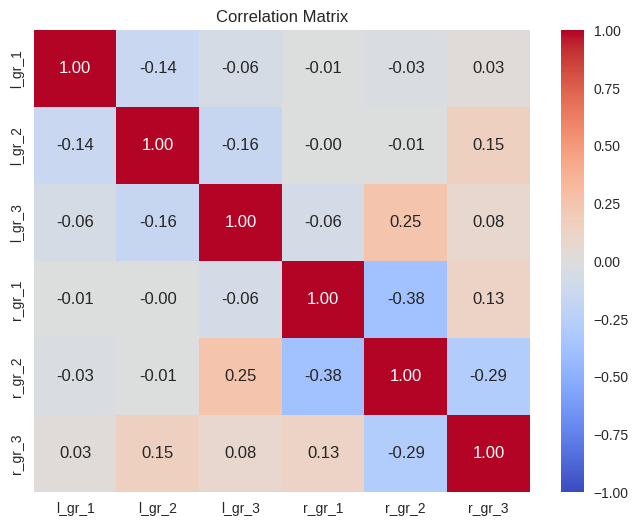

In [19]:
plot_corr(X_train_graphemes)

In [20]:
X_train_graphemes

,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
1333,m,o,g,a,l,g
3186,p,r,i,e,j,u
4657,v,r,a,i,t,i
3232,p,r,i,a,l,k
4795,z,n,a,u,j,a
...,...,...,...,...,...,...
646,i,s,k,i,t,s
2131,o,s,v,a,l,i
3511,r,e,k,o,a,k
4429,u,s,p,o,e,p


In [21]:
X_train_graphemes, X_test_graphemes, X_valid_graphemes = one_hot_encode(
    X_train_graphemes,
    X_test_graphemes,
    X_valid_graphemes,
)

In [22]:
X_train_graphemes.shape, X_test_graphemes.shape, X_valid_graphemes.shape

((4418, 130), (496, 130), (45, 130))

[[ 21   2   1]
 [  0 209  32]
 [  0  18 213]]
              precision    recall  f1-score   support

        both       1.00      0.88      0.93        24
         imp       0.91      0.87      0.89       241
        perf       0.87      0.92      0.89       231

    accuracy                           0.89       496
   macro avg       0.93      0.89      0.91       496
weighted avg       0.90      0.89      0.89       496



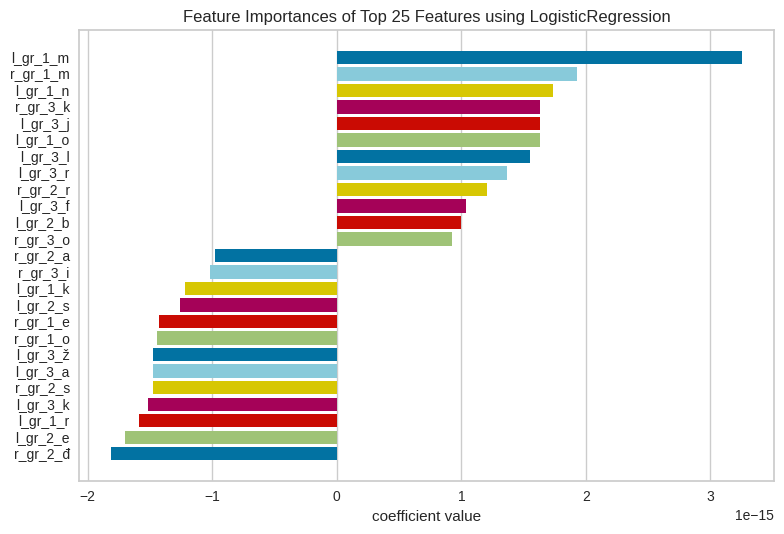

In [23]:
experiment(
    lambda: LogisticRegression(),
    X_train_graphemes,
    X_test_graphemes,
    y_train["aspect"],
    y_test["aspect"]
)

[[ 24   0   0]
 [  0 227  14]
 [  0   6 225]]
              precision    recall  f1-score   support

        both       1.00      1.00      1.00        24
         imp       0.97      0.94      0.96       241
        perf       0.94      0.97      0.96       231

    accuracy                           0.96       496
   macro avg       0.97      0.97      0.97       496
weighted avg       0.96      0.96      0.96       496



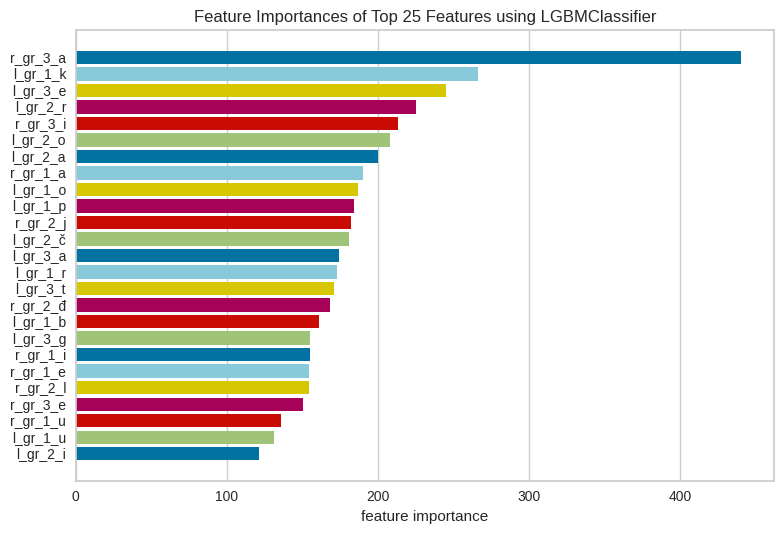

In [24]:
experiment(
    lambda: LGBMClassifier(verbose=-1),
    X_train_graphemes,
    X_test_graphemes,
    y_train["aspect"],
    y_test["aspect"]
)

[[ 24   0   0]
 [  0 222  19]
 [  0  15 216]]
              precision    recall  f1-score   support

        both       1.00      1.00      1.00        24
         imp       0.94      0.92      0.93       241
        perf       0.92      0.94      0.93       231

    accuracy                           0.93       496
   macro avg       0.95      0.95      0.95       496
weighted avg       0.93      0.93      0.93       496



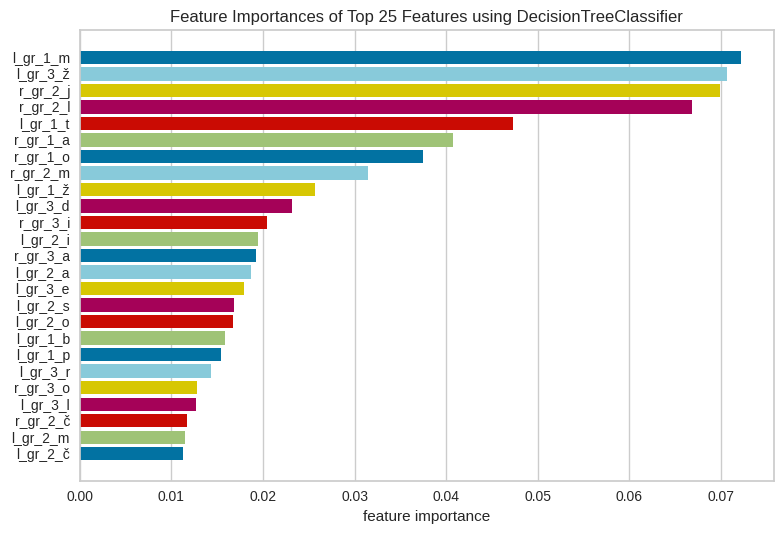

In [25]:
experiment(
    lambda: DecisionTreeClassifier(),
    X_train_graphemes,
    X_test_graphemes,
    y_train["aspect"],
    y_test["aspect"]
)